In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)
setattr(pd.Series,'ends',ends)

In [4]:
PATH = './../'
PATH_DATA_RAW = PATH + 'data/raw/'
PATH_DATA_INTERMEDIATE = PATH + 'data/intermediate/'
PATH_DATA_PROCESSED = PATH + 'data/processed/'

# Loading data

In [5]:
year_init=1995
year_final=2015
collab_df = pd.read_csv(PATH_DATA_INTERMEDIATE + 'WTCF_0001_reduced_{year1}-{year2}.csv'.format(year1=year_init, 
                                                                                         year2=year_final), 
                        dtype={'hs_product_code':'str'})
collab_df['hs_product_code'] = collab_df['hs_product_code'].str.zfill(4)
collab_df.shape

(547546, 5)

In [6]:
collab_df.ends(2)

,location_code,hs_product_code,share,y,year
0,ALB,0101,-9.632264,-2.265118,1995
1,ARE,0101,-5.044526,-1.618304,1995
547544,ANS,9706,-9.952568,-2.297831,2010
547545,ANS,9706,-8.679755,-2.160993,2015


In [7]:
collab_df.ends(3)

,location_code,hs_product_code,share,y,year
0,ALB,0101,-9.632264,-2.265118,1995
1,ARE,0101,-5.044526,-1.618304,1995
2,ARE,0101,-4.916745,-1.592647,2000
547543,ANS,9706,-10.901539,-2.388904,2005
547544,ANS,9706,-9.952568,-2.297831,2010
547545,ANS,9706,-8.679755,-2.160993,2015


In [8]:
collab_df.groupby(by=['year']).describe(include='all').T

year                        1995      2000      2005      2010      2015
location_code   count      99634    108815    112950    113461    112686
                unique       116       116       116       116       116
                top          ANS       FRA       NLD       ZAF       USA
                freq        1221      1221      1221      1221      1215
                mean         NaN       NaN       NaN       NaN       NaN
                std          NaN       NaN       NaN       NaN       NaN
                min          NaN       NaN       NaN       NaN       NaN
                25%          NaN       NaN       NaN       NaN       NaN
                50%          NaN       NaN       NaN       NaN       NaN
                75%          NaN       NaN       NaN       NaN       NaN
                max          NaN       NaN       NaN       NaN       NaN
hs_product_code count      99634    108815    112950    113461    112686
                unique      1221      1221      1221      1221      1221
                top         9403      8525      8536      9403      7616
                freq         116       116       116       116       116
                mean         NaN       NaN       NaN       NaN       NaN
                std          NaN       NaN       NaN       NaN       NaN
                min          NaN       NaN       NaN       NaN       NaN
                25%          NaN       NaN       NaN       NaN       NaN
                50%          NaN       NaN       NaN       NaN       NaN
                75%          NaN       NaN       NaN       NaN       NaN
                max          NaN       NaN       NaN       NaN       NaN
share           count      99634    108815    112950    113461    112686
                unique       NaN       NaN       NaN       NaN       NaN
                top          NaN       NaN       NaN       NaN       NaN
                freq         NaN       NaN       NaN       NaN       NaN
                mean    -9.80788  -10.0269  -10.1994  -10.2951  -10.3715
                std       2.6455   2.74998   2.88065   2.97152   3.04109
                min     -20.6843  -21.9383   -21.659  -22.9513  -22.9565
                25%      -11.614  -11.8758  -12.1222  -12.2545  -12.3618
                50%     -9.72567   -9.9143   -10.039  -10.1146  -10.1596
                75%     -7.93989  -8.07378  -8.13378  -8.15731  -8.18656
                max    -0.182683 -0.318342 -0.249664 -0.493245 -0.498353
y               count      99634    108815    112950    113461    112686
                unique       NaN       NaN       NaN       NaN       NaN
                top          NaN       NaN       NaN       NaN       NaN
                freq         NaN       NaN       NaN       NaN       NaN
                mean    -2.24295  -2.26404  -2.27891  -2.28656  -2.29266
                std     0.295465  0.298253  0.305527  0.310963  0.315242
                min     -3.02937  -3.08823  -3.07542  -3.13337   -3.1336
                25%     -2.45221   -2.4745  -2.49504  -2.50589  -2.51461
                50%     -2.27477  -2.29398  -2.30648  -2.31398  -2.31841
                75%      -2.0719  -2.08862  -2.09603  -2.09891  -2.10249
                max          1.7   1.14463   1.38764   0.70675  0.696446

In [9]:
(collab_df.isnull().sum().sum(), collab_df.isna().sum().sum())

(0, 0)

# Fast ai

In [10]:
from fastai import *
from fastai.collab import * 

The model is basically the following:

$$
\text{argmin}_{a,b,\mathbf{\gamma},\mathbf{\delta}}\sum_{c,p\in\mathcal{O}} \left(r_{c,p} - a_c - b_p  -\mathbf{\delta}^T_p\mathbf{\gamma}_c\right)^2 + w\left( \left\|\mathbf{a}\right\|^2 + \left\|\mathbf{b}\right\|^2 + \left\|\mathbf{\delta}\right\|^2 + \left\|\mathbf{\gamma}\right\|^2\right)
$$

where $r_{c,p}$ is the rating of country $c$ in product $p$. If $X_{c,p}$ is total exports in a given year, here we will model either $\text{'share'}=\ln(X_{c,p})$ or $\text{'y'}=-\ln(-\ln(X_{c,p}/\sum_p X_{c,p}))$. The minimization is over the embeddings representing countries and products, where $\mathbf{\gamma}_c$ is a vector in $\mathbb{R}^K$ representing country $c$ and $\mathbf{\delta}_p$ is a vector in $\mathbb{R}^K$ representing product $p$. Here, $K$ is the dimension of these embeddings (the lower rank representation of the matrix of ratings). Note that the sum is over the set $\mathcal{O}$, which is the pairs of country-product combinations that are actually _observed_. In other words, we do not impute any missing values.

Notice that we also include some biases, $a_c$ and $b_p$, representing a country or product's inherent average rating.

I say that this is what fastai does "basically", because there is an activation function at the end, which ensures that the ratings are within a fixed range.


### Setting some parameters

In [11]:
# Train year
year_train = 1995

# Test year
year_test = 1995

# Columns
user_col = 'location_code'
item_col='hs_product_code'

# Values
rating_col='y'
prediction_col= 'pred_' + rating_col

In [12]:
ctry_names = sorted(collab_df[user_col].unique())
prod_names = sorted(collab_df[item_col].unique())

In [13]:
test_df = pd.DataFrame(list(itertools.product(ctry_names, prod_names)),
                      columns = [user_col, item_col])
# test_df = test_df.merge(collab_df[collab_df['year']==year_test], 
#                         how = 'left',
#                         on=[user_col, item_col])

In [14]:
print(test_df.shape)
test_df.ends(3)

(141636, 2)


,location_code,hs_product_code
0,AGO,0101
1,AGO,0102
2,AGO,0103
141633,ZWE,9704
141634,ZWE,9705
141635,ZWE,9706


In [15]:
from scipy.stats import norm

In [18]:
# Looking at the ranges of the dependent variable, and what a normal distribution would predict
muest = np.mean(collab_df[rating_col])
sdest = np.std(collab_df[rating_col])
num_rows = collab_df[collab_df['year']==year_train].shape[0]
((collab_df[collab_df['year']==year_train][rating_col].min(), 
  collab_df[collab_df['year']==year_train][rating_col].max()), 
(norm.ppf(1.0/num_rows, loc=muest, scale=sdest), 
 norm.ppf(1.0-1.0/num_rows, loc=muest, scale=sdest)))

((-3.0293737296903505, 1.7000022081043389),
 (-3.5784723027973246, -0.9691825266446394))

In [20]:
dep_range = (-3.5, 2.5)
dep_range

(-3.5, 2.5)

In [21]:
data = CollabDataBunch.from_df(collab_df[collab_df['year']==year_train], 
                          user_name = user_col,
                          item_name = item_col,
                          rating_name = rating_col,
                           seed = 42,
                          test = test_df,
                          path = PATH) 

In [22]:
# Checking that there are no classes in the validation/test sets that are only in the training

# Validation
print(set(data.valid_ds.classes[user_col]) - set(data.train_ds.classes[user_col]))
print(set(data.valid_ds.classes[item_col]) - set(data.train_ds.classes[item_col]))

# Test
print(set(data.test_ds.classes[user_col]) - set(data.train_ds.classes[user_col]))
print(set(data.test_ds.classes[item_col]) - set(data.train_ds.classes[item_col]))

set()
set()
set()
set()


## Starting the fitting procedure

In [23]:
learn = collab_learner(data, n_factors=25, y_range=dep_range)

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-01


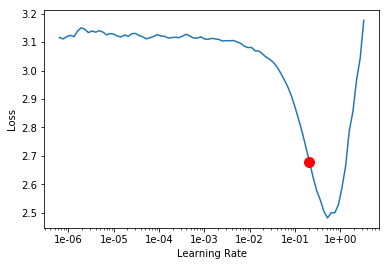

In [25]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(15, 2e-01, wd=0.1)

epoch,train_loss,valid_loss
1,0.106508,0.113620
2,0.455261,0.495040
3,1.132013,1.087486
4,1.642326,1.607861
5,1.738034,1.769480
6,1.590509,1.593038
7,1.313941,1.380810
8,1.136210,1.124856
9,0.799760,0.745053
10,0.415009,0.408892


In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


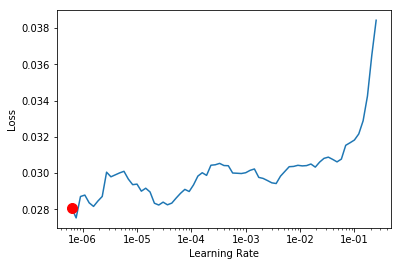

In [28]:
learn.recorder.plot()

In [29]:
learn.save('collab_fittedon_{var}_{year1}-{year2}_fit_1'.format(var=rating_col, year1=year_train, year2=year_test))

In [30]:
learn.fit_one_cycle(3, 2e-07)

epoch,train_loss,valid_loss
1,0.032299,0.044846
2,0.031235,0.044845
3,0.030292,0.044845


In [31]:
learn.save('collab_fittedon_{var}_{year1}-{year2}_fit_2'.format(var=rating_col, year1=year_train, year2=year_test))

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-04


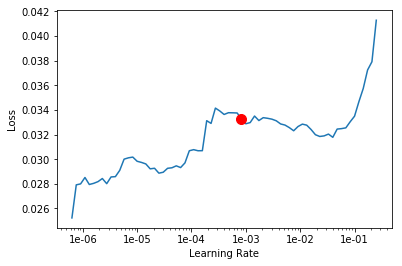

In [33]:
learn.recorder.plot()

In [ ]:
# learn.fit_one_cycle(2, 2e-01)

## load model, if necessary

In [ ]:
load_prev_model = True
# train from previous years
# data = CollabDataBunch.from_df(collab_df[collab_df['year'].isin([1995,2005])])
if load_prev_model:
    data = CollabDataBunch.from_df(collab_df[collab_df['year']==year_train], 
                          user_name = user_col,
                          item_name = item_col,
                          rating_name = rating_col,
                           seed = 42,
                          test = test_df,
                          path = PATH)  

    learn = collab_learner(data, n_factors=25, y_range=dep_range)

    learn = learn.load('collab_fittedon_{var}_{year1}-{year2}_fit_2'.format(var=rating_col, year1=year_train, year2=year_test))

## Let's check some results

In [34]:
from sklearn.metrics import mean_squared_error
def my_rmse(yreal, ypred):
    idxreal = np.where(yreal.notnull())[0]
    idxpred = np.where(ypred.notnull())[0]
    idx = list(set(idxreal).intersection(set(idxpred)))
    return(np.sqrt(mean_squared_error(yreal.iloc[idx], ypred.iloc[idx])))

In [35]:
learn.show_results()

location_code,hs_product_code,target,prediction
DNK,0406,-1.33333,-1.5428753
CRI,6304,-2.3899455,-2.3055763
CHE,1106,-2.2881796,-2.5056667
PRK,4014,-2.2382922,-2.2877884
MDA,6113,-2.5339735,-2.3620908


In [36]:
(learn.get_idx(['FIN', 'NOR', 'CAN'], is_item=False),
 learn.get_idx(['1001', '3215', '3701'], is_item=True))

(tensor([36, 80, 16]), tensor([ 87, 374, 402]))

In [37]:
learn.model.forward(tensor([36]), tensor([87]))

tensor([-2.0390])

In [38]:
train_preds, _ = learn.get_preds(ds_type=DatasetType.Train)
train_preds

tensor([-2.2880, -2.3847, -2.2366,  ..., -2.1159, -2.1604, -2.3755])

In [39]:
len(train_preds)

79680

## Let's see the biases

The neural network implementation of a collaborative filtering algorithm in fastai includes some user and item biases. Maybe, these biases can be good candidates to represent the implicit knowhow of countries and complexity of products. 

In [40]:
total_users, total_items = learn.data.classes.values()

In [41]:
user_idx = learn.get_idx(ctry_names, is_item=False)
item_idx = learn.get_idx(prod_names, is_item=True)

In [42]:
ctry_biases = learn.bias(ctry_names, is_item=False)
prod_biases = learn.bias(prod_names, is_item=True)

In [43]:
ctry_biases_dict = [(cn, np.round(cb, 3)) for cn,cb in zip(ctry_names, ctry_biases)]
prod_biases_dict = [(pn, np.round(pb, 3)) for pn,pb in zip(prod_names, prod_biases)]

In [44]:
item1 = lambda x: x[1]

In [45]:
sorted(ctry_biases_dict, key=item1)

[('BGD', tensor(-1.0790)),
 ('GHA', tensor(-1.0690)),
 ('CIV', tensor(-1.0610)),
 ('PNG', tensor(-1.0600)),
 ('GIN', tensor(-1.0590)),
 ('PAK', tensor(-1.0580)),
 ('JPN', tensor(-1.0450)),
 ('ECU', tensor(-1.0400)),
 ('CUB', tensor(-1.0360)),
 ('MAR', tensor(-1.0320)),
 ('LKA', tensor(-1.0280)),
 ('UZB', tensor(-1.0270)),
 ('DOM', tensor(-1.0250)),
 ('PHL', tensor(-1.0180)),
 ('PAN', tensor(-1.0170)),
 ('CMR', tensor(-1.0160)),
 ('NGA', tensor(-1.0160)),
 ('JAM', tensor(-1.0150)),
 ('PER', tensor(-1.0130)),
 ('IRN', tensor(-1.0120)),
 ('VNM', tensor(-1.0100)),
 ('HND', tensor(-1.0090)),
 ('CHL', tensor(-1.0050)),
 ('MDG', tensor(-1.0040)),
 ('LBY', tensor(-0.9990)),
 ('MYS', tensor(-0.9980)),
 ('GAB', tensor(-0.9930)),
 ('URY', tensor(-0.9900)),
 ('JOR', tensor(-0.9890)),
 ('KOR', tensor(-0.9890)),
 ('NZL', tensor(-0.9890)),
 ('BOL', tensor(-0.9880)),
 ('CRI', tensor(-0.9870)),
 ('NIC', tensor(-0.9860)),
 ('SAU', tensor(-0.9860)),
 ('IRL', tensor(-0.9850)),
 ('TUN', tensor(-0.9840)),
 

In [46]:
sorted(prod_biases_dict, key=item1)

[('2705', tensor(-0.6540)),
 ('0907', tensor(-0.6060)),
 ('8006', tensor(-0.6020)),
 ('4815', tensor(-0.5950)),
 ('5110', tensor(-0.5950)),
 ('6602', tensor(-0.5900)),
 ('9604', tensor(-0.5780)),
 ('8005', tensor(-0.5750)),
 ('1903', tensor(-0.5660)),
 ('7417', tensor(-0.5650)),
 ('5006', tensor(-0.5610)),
 ('1802', tensor(-0.5600)),
 ('1505', tensor(-0.5560)),
 ('7805', tensor(-0.5560)),
 ('0502', tensor(-0.5530)),
 ('4204', tensor(-0.5530)),
 ('7107', tensor(-0.5490)),
 ('3211', tensor(-0.5460)),
 ('0509', tensor(-0.5450)),
 ('1402', tensor(-0.5450)),
 ('5302', tensor(-0.5450)),
 ('8003', tensor(-0.5440)),
 ('9104', tensor(-0.5410)),
 ('5809', tensor(-0.5400)),
 ('9112', tensor(-0.5370)),
 ('4502', tensor(-0.5360)),
 ('7906', tensor(-0.5360)),
 ('9204', tensor(-0.5360)),
 ('0903', tensor(-0.5330)),
 ('8109', tensor(-0.5300)),
 ('9302', tensor(-0.5300)),
 ('0906', tensor(-0.5290)),
 ('6507', tensor(-0.5280)),
 ('4405', tensor(-0.5270)),
 ('5910', tensor(-0.5260)),
 ('7111', tensor(-0.

### Let's check the embeddings

In [47]:
ctry_weights = learn.weight(ctry_names, is_item=False)
prod_weights = learn.weight(prod_names, is_item=True)
(ctry_weights.shape, prod_weights.shape)

(torch.Size([116, 25]), torch.Size([1221, 25]))

In [48]:
# To visualize, let's apply PCA or Spectral Embeddings
ctry_wpca = ctry_weights.pca(2)
prod_wpca = prod_weights.pca(2)
(ctry_wpca.shape, prod_wpca.shape)

(torch.Size([116, 2]), torch.Size([1221, 2]))

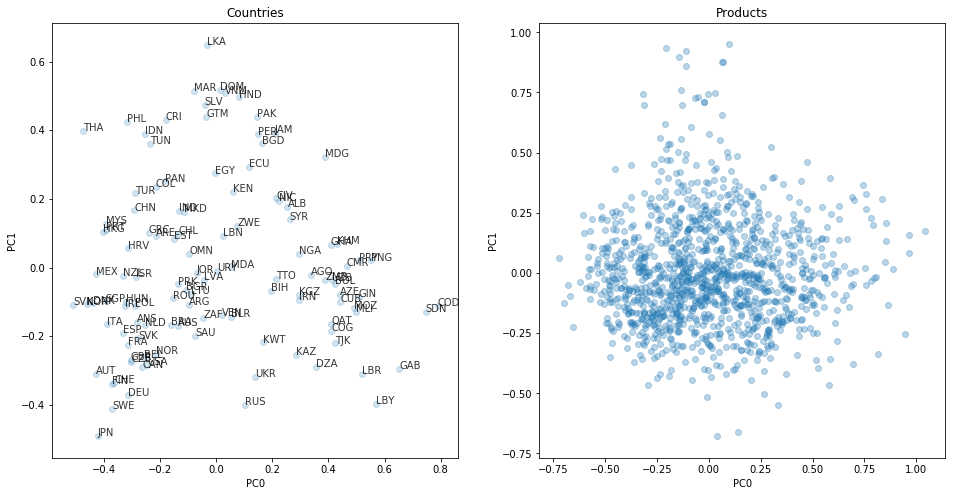

In [50]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.scatter(ctry_wpca[:,0], ctry_wpca[:,1], alpha=0.2)
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.title("Countries")
for i, txt in enumerate(ctry_names):
    plt.annotate(txt, (ctry_wpca[i,0], ctry_wpca[i,1]), 
                 #alpha=(ctry_biases[i].item() - ctry_biases.min().item())/(ctry_biases.max().item()-ctry_biases.min().item()),
                alpha = 0.8)

plt.subplot(1, 2, 2)
plt.scatter(prod_wpca[:,0], prod_wpca[:,1],
            #alpha=(prod_biases.numpy() - prod_biases.min().item())/(prod_biases.max().item()-prod_biases.min().item()),
            alpha = 0.3)
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.title("Products")

plt.show()

# Checking the predictions applied to 2015

The model we have just trained is cross-sectional. However, we are interested in assessing whether such model can predict changes in the export baskets of countries.

We can play with the following ideas:
1. We can simply check whether the same values are stable in time. That is, simply compare the values predicted for the training year with the values of next year.
2. We can generate the predictions for the training year, check the differences with the real values, and assess whether these differences predict the _change_ from the training year to next.
3. We can generate the predictions for the missing exports in the training year, and assess whether those top predictions appeared in the next year.

### However, let's compare the real in training numbers with those of real in next year

In [52]:
widedf = collab_df.pivot_table(index=[user_col, item_col], columns='year').reset_index()
widedf.ends(2)

location_code hs_product_code      share                        \
year                                       1995       2000       2005   
0                AGO            0102        NaN  -5.431686  -9.197963   
1                AGO            0103        NaN  -9.919305        NaN   
129025           ZWE            9705  -6.727407  -6.870992  -7.038993   
129026           ZWE            9706 -11.802350 -16.592924 -12.543200   

                                     y                                          
year         2010       2015      1995      2000      2005      2010      2015  
0      -14.080567 -12.867580       NaN -1.692250 -2.218982 -2.644796 -2.554711  
1             NaN        NaN       NaN -2.294483       NaN       NaN       NaN  
129025  -5.374691  -6.732000 -1.906190 -1.927309 -1.951465 -1.681701 -1.906872  
129026        NaN -12.867751 -2.468299 -2.808976 -2.529179       NaN -2.554724

In [53]:
newcolumns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in widedf.columns]
widedf.columns = newcolumns
widedf.ends(2)

,location_code,hs_product_code,share_1995,share_2000,share_2005,share_2010,share_2015,y_1995,y_2000,y_2005,y_2010,y_2015
0,AGO,0102,NaN,-5.431686,-9.197963,-14.080567,-12.867580,NaN,-1.692250,-2.218982,-2.644796,-2.554711
1,AGO,0103,NaN,-9.919305,NaN,NaN,NaN,NaN,-2.294483,NaN,NaN,NaN
129025,ZWE,9705,-6.727407,-6.870992,-7.038993,-5.374691,-6.732000,-1.906190,-1.927309,-1.951465,-1.681701,-1.906872
129026,ZWE,9706,-11.802350,-16.592924,-12.543200,NaN,-12.867751,-2.468299,-2.808976,-2.529179,NaN,-2.554724


In [54]:
widedf.shape

(129027, 12)

In [55]:
(widedf.isnull().sum().sum(), widedf.isna().sum().sum())

(195178, 195178)

In [56]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
preds

tensor([-1.9763, -1.8983, -2.0505,  ..., -2.4574, -2.3406, -2.3161])

In [57]:
test_df[prediction_col] = preds.numpy()

In [58]:
test_df.ends(5)

,location_code,hs_product_code,pred_y
0,AGO,0101,-1.976342
1,AGO,0102,-1.898345
2,AGO,0103,-2.050479
3,AGO,0104,-1.786094
4,AGO,0105,-2.087532
141631,ZWE,9702,-2.507555
141632,ZWE,9703,-2.301245
141633,ZWE,9704,-2.457434
141634,ZWE,9705,-2.340584
141635,ZWE,9706,-2.316133


### Do differences in prediction vs training year predict changes?

In [59]:
final_df = test_df.merge(widedf, on=[user_col, item_col], how='left')
final_df[f'diff_{year_train}_pred'] = final_df[rating_col + f'_{year_train}'] - final_df[prediction_col]
final_df[f'diff_{year_train+5}_{year_train}'] = final_df[rating_col + f'_{year_train+5}'] - final_df[rating_col + f'_{year_train}']

final_df.ends(3)

,location_code,hs_product_code,pred_y,share_1995,share_2000,share_2005,share_2010,share_2015,y_1995,y_2000,y_2005,y_2010,y_2015,diff_1995_pred,diff_2000_1995
0,AGO,0101,-1.976342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AGO,0102,-1.898345,NaN,-5.431686,-9.197963,-14.080567,-12.867580,NaN,-1.692250,-2.218982,-2.644796,-2.554711,NaN,NaN
2,AGO,0103,-2.050479,NaN,-9.919305,NaN,NaN,NaN,NaN,-2.294483,NaN,NaN,NaN,NaN,NaN
141633,ZWE,9704,-2.457434,-14.533808,-9.467848,-11.356324,-14.454667,-13.460935,-2.676478,-2.247902,-2.429775,-2.671017,-2.599792,-0.219044,0.428576
141634,ZWE,9705,-2.340584,-6.727407,-6.870992,-7.038993,-5.374691,-6.732000,-1.906190,-1.927309,-1.951465,-1.681701,-1.906872,0.434394,-0.021119
141635,ZWE,9706,-2.316133,-11.802350,-16.592924,-12.543200,NaN,-12.867751,-2.468299,-2.808976,-2.529179,NaN,-2.554724,-0.152165,-0.340678


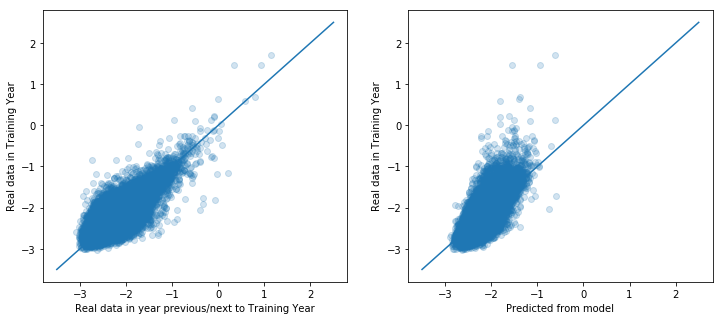

In [62]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.scatter(final_df[rating_col+f'_{year_train+5}'].values, final_df[rating_col+f'_{year_train}'].values, alpha=0.2)
plt.plot(dep_range, dep_range)
plt.xlabel("Real data in year previous/next to Training Year")
plt.ylabel("Real data in Training Year")

plt.subplot(1, 2, 2)
plt.scatter(final_df[prediction_col].values, final_df[rating_col+f'_{year_train}'].values, alpha=0.2)
plt.plot(dep_range, dep_range)
plt.xlabel("Predicted from model")
plt.ylabel("Real data in Training Year")

plt.show()

In [63]:
('Predicting 2010 with 2005 gives RMSE = {:.3f}'.format(my_rmse(final_df[rating_col+f'_{year_train+5}'], 
                                                                final_df[rating_col+f'_{year_train}'])),
'Predicting 2010 with model gives RMSE = {:.3f}'.format(my_rmse(final_df[prediction_col], 
                                                                final_df[rating_col+f'_{year_train}'])))

('Predicting 2010 with 2005 gives RMSE = 0.165',
 'Predicting 2010 with model gives RMSE = 0.185')

We want to understand changes in the export baskets, from $r_{c,p}(t)$ to $r_{c,p}(t+\Delta t)$. Let us denote this change with the letter 'g', from 'growth': 

$$
g_{c,p}(t) = r_{c,p}(t+\Delta t) - r_{c,p}(t).
$$

Let us compute the difference between the prediction from the model, and the real data:

$$
D_{c,p}(t) = r_{c,p}(t) - \widehat{r_{c,p}}(t).
$$

The question is whether the following regression specification is statistically predictive:

$$
g_{c,p}(t) = \beta_0 + \beta_1 r_{c,p}(t) + \beta_2 D_{c,p}(t) + \varepsilon_{c,p,t}.
$$

This regression model states that the change from one period to the next is a linear function of 
- an intercept (i.e., perhaps there is an average tendency for change), which we expect to be positive,
- the current level (i.e., perhaps there is some sort of reversion to the mean, whereby atypical high levels of $r_{c,p}(t)$ are followed by a subsequent decrease), with a coefficient we expect to be negative,
- and the deviation between the current level and what our collaborative filtering model stated $r_{c,p}(t)$ _should_ have been (i.e., perhaps reality is always trying to revert back to some expected value), with a coefficient we also expect to be negative.

We note that the model could in principle be re-written as:
$$
r_{c,p}(t+\Delta t) - r_{c,p}(t) = \beta_0 + \beta_1 r_{c,p}(t) + \beta_2 (r_{c,p}(t) - \widehat{r_{c,p}}(t)) + \varepsilon_{c,p,t},
$$
which becomes

$$
r_{c,p}(t+\Delta t) = \beta_0 + (1 + \beta_1 + \beta_2) r_{c,p}(t) - \beta_2 \widehat{r_{c,p}}(t) + \varepsilon_{c,p,t},
$$

and modeled as 

$$
r_{c,p}(t+\Delta t) = \alpha_0 + \alpha_1 r_{c,p}(t) + \alpha_2 \widehat{r_{c,p}}(t) + \varepsilon_{c,p,t},
$$



In [64]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [65]:
results = smf.ols(f'diff_{year_train+5}_{year_train} ~ {rating_col}_{year_train} + diff_{year_train}_pred', 
                  data=final_df).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         diff_2000_1995   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     7303.
Date:                Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                        12:09:41   Log-Likelihood:                 42767.
No. Observations:               93611   AIC:                        -8.553e+04
Df Residuals:                   93608   BIC:                        -8.550e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0569      0.005    -10.

In [66]:
results2 = smf.ols(f'{rating_col}_{year_train+5} ~ {rating_col}_{year_train} + {prediction_col}', 
                  data=final_df).fit()

# Inspect the results
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                 y_2000   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                 1.273e+05
Date:                Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                        12:11:34   Log-Likelihood:                 42767.
No. Observations:               93611   AIC:                        -8.553e+04
Df Residuals:                   93608   BIC:                        -8.550e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0569      0.005    -10.888      0.0

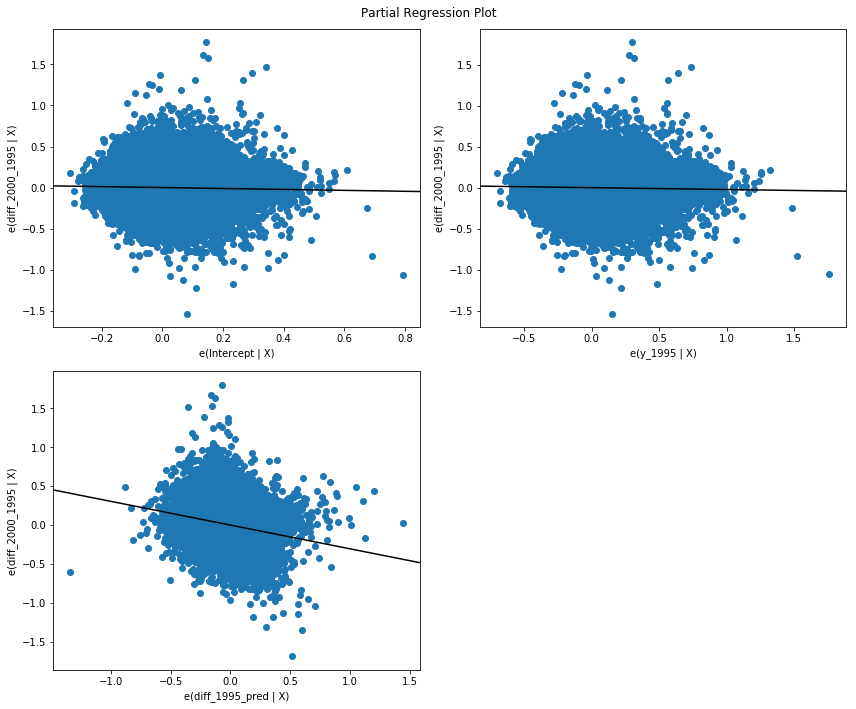

In [67]:
fig = plt.figure(figsize=(12,10))
fig = sm.graphics.plot_partregress_grid(results, fig=fig)

In [68]:
# fix, ax = plt.subplots(figsize=(12,14))
# fig = sm.graphics.plot_partregress(f'diff_{year_train+5}_{year_train}', f'diff_{year_train}_pred', 
#                                    [f'{rating_col}_{year_train}'], 
#                                    data=final_df[~final_df[f'diff_{year_train+5}_{year_train}'].isnull()], 
#                                    ax=ax)

# Prediction at the extensive margin

All previous predictions were done at the intensive margin. That is, for a given country, we looked at the products that were exported in the training year and then were also exported in the next year, and looked whether a model could explain the change in that period of time.

Here, we want to look at the country-product combinations that were missing in the current training year data, and see if we can predict/explain the time of appearance.

People typically do this by creating binary variables to model whether the product "appeared" or not in a fixed time window. That is, people typically define the following matrix:
\begin{eqnarray}
    A_{c,p}(t+\Delta t) = 
    \begin{cases}
    1,\quad\text{if}~r_{c,p}(t)=0~\&~r_{c,p}(t+\Delta t)>0 \\
    0,\quad\text{otherwise}
    \end{cases}
\end{eqnarray}
or something like that (e.g., they might add some conditions that the production needs to be sustained for more than one period).

A simple model from this point of view could be

\begin{eqnarray}
    \text{logit}\left(A_{c,p}(t+\Delta t)\right) = 
        \theta_0 + \theta_1 \widehat{r_{c,p}}(t) + \varepsilon_{c,p,t},
\end{eqnarray}
where one expects that $\theta_1$ is positive (and significant).


Here, however, I am going to take a different route. My hypothesis is that the larger $\widehat{r_{c,p}}(t)$, the more likely it is the product will appear soon, rather than later. 

Thus, we create the following matrix:

\begin{eqnarray}
    T_{c,p}(t) = \text{min}\left\{\tau~:~r_{c,p}(t)=0~\&~r_{c,p}(t+\tau)>0\right\}.
\end{eqnarray}

That is, it is the matrix in which the element is the number of years until the product is exported, conditioned it is currently not being exported.

Our dataset goes from 1995 until 2015, and 20 years is not a long time. Hence, a better exercise would be to use the SITC data which starts in 1962. 

A simple regression model to test this hypothesis would be:

\begin{eqnarray}
    T_{c,p}(t) = \theta_0 + \theta_1 \widehat{r_{c,p}}(t) + \varepsilon_{c,p,t},
\end{eqnarray}
and here we expect that $\theta_1$ is **negative**.

There is certain equivalency between these two approaches. Suppose that the probability of tossing 'heads' with a weighted coin is $p=0.04$. What is the expected number $T$ of tosses until we observe 'heads'? Assuming each toss is independent and the probability does not change, the answer is $\mathbb{E}[T] = 1/p$ which yields $1/0.04 = 25$ tosses.

### Let's create the corresponding column of "time until appearance"

In [69]:
final_df.head(5)

,location_code,hs_product_code,pred_y,share_1995,share_2000,share_2005,share_2010,share_2015,y_1995,y_2000,y_2005,y_2010,y_2015,diff_1995_pred,diff_2000_1995
0,AGO,0101,-1.976342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AGO,0102,-1.898345,NaN,-5.431686,-9.197963,-14.080567,-12.86758,NaN,-1.692250,-2.218982,-2.644796,-2.554711,NaN,NaN
2,AGO,0103,-2.050479,NaN,-9.919305,NaN,NaN,NaN,NaN,-2.294483,NaN,NaN,NaN,NaN,NaN
3,AGO,0104,-1.786094,NaN,-6.960319,-9.999290,NaN,NaN,NaN,-1.940225,-2.302514,NaN,NaN,NaN,NaN
4,AGO,0105,-2.087532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
allyears = sorted(collab_df.year.unique())
print(allyears)

cols2look = [rating_col+f'_{tau}' for tau in allyears]
print(cols2look)

[1995, 2000, 2005, 2010, 2015]
['y_1995', 'y_2000', 'y_2005', 'y_2010', 'y_2015']


In [72]:
final_df['Tcp'] = 0.0
final_df['Tcp'] = final_df[cols2look].isnull().idxmin(axis=1).apply(lambda s: int(s[2:6]) - year_train)
final_df.loc[final_df[cols2look].isnull().apply(all, axis=1), 'Tcp'] = np.nan

In [73]:
final_df.ends(3)

,location_code,hs_product_code,pred_y,share_1995,share_2000,share_2005,share_2010,share_2015,y_1995,y_2000,y_2005,y_2010,y_2015,diff_1995_pred,diff_2000_1995,Tcp
0,AGO,0101,-1.976342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AGO,0102,-1.898345,NaN,-5.431686,-9.197963,-14.080567,-12.867580,NaN,-1.692250,-2.218982,-2.644796,-2.554711,NaN,NaN,5.0
2,AGO,0103,-2.050479,NaN,-9.919305,NaN,NaN,NaN,NaN,-2.294483,NaN,NaN,NaN,NaN,NaN,5.0
141633,ZWE,9704,-2.457434,-14.533808,-9.467848,-11.356324,-14.454667,-13.460935,-2.676478,-2.247902,-2.429775,-2.671017,-2.599792,-0.219044,0.428576,0.0
141634,ZWE,9705,-2.340584,-6.727407,-6.870992,-7.038993,-5.374691,-6.732000,-1.906190,-1.927309,-1.951465,-1.681701,-1.906872,0.434394,-0.021119,0.0
141635,ZWE,9706,-2.316133,-11.802350,-16.592924,-12.543200,NaN,-12.867751,-2.468299,-2.808976,-2.529179,NaN,-2.554724,-0.152165,-0.340678,0.0


### Let's run the regression

In [75]:
reversed_extensive_ols = smf.ols(f'{prediction_col} ~ Tcp', 
                  data=final_df).fit()

# Inspect the results
print(reversed_extensive_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 pred_y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1686.
Date:                Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                        12:15:30   Log-Likelihood:                 18615.
No. Observations:              129027   AIC:                        -3.723e+04
Df Residuals:                  129025   BIC:                        -3.721e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2272      0.001  -3467.227      0.0

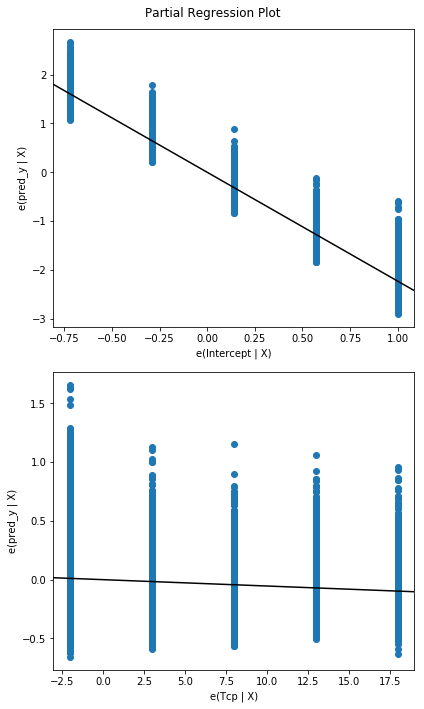

In [76]:
fig = plt.figure(figsize=(6,10))
fig = sm.graphics.plot_partregress_grid(reversed_extensive_ols, fig=fig)

In [74]:
extensive_ols = smf.ols(f'Tcp ~ {prediction_col}', 
                  data=final_df).fit()

# Inspect the results
print(extensive_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    Tcp   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1686.
Date:                Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                        12:13:51   Log-Likelihood:            -3.7406e+05
No. Observations:              129027   AIC:                         7.481e+05
Df Residuals:                  129025   BIC:                         7.481e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2886      0.130    -25.213      0.0

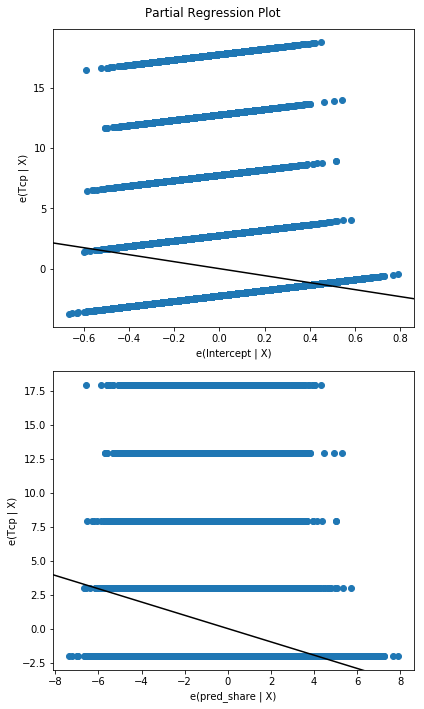

In [175]:
fig = plt.figure(figsize=(6,10))
fig = sm.graphics.plot_partregress_grid(extensive_ols, fig=fig)

# Check on a new data set

In [ ]:
def score_direct(learner, test_df, user_col, item_col, prediction_col, top_k=0):
    """score all users+movies provided and reduce to top_k items per user if top_k>0"""
    # replace values not known to the model with #na#
    total_users, total_items = learner.data.classes.values()
    test_df.loc[~test_df[user_col].isin(total_users),user_col] = total_users[0]
    test_df.loc[~test_df[item_col].isin(total_items),item_col] = total_items[0]
   
    # map ids to embedding ids 
    u = learner.get_idx(test_df[user_col], is_item=False)
    m = learner.get_idx(test_df[item_col], is_item=True)
    
    # score the pytorch model
    pred = learner.model.forward(u, m)
    scores = pd.DataFrame({user_col: test_df[user_col], item_col:test_df[item_col], prediction_col:pred})
    scores =  scores.sort_values([user_col,prediction_col],ascending=[True,False])
    if top_k > 0:
        top_scores = scores.groupby(user_col).head(top_k).reset_index(drop=True)
    else:
        top_scores = scores
    return(top_scores)


In [ ]:
score_direct(learn, collab_df[collab_df['year']==year_train], 
             user_col='location_code',
             item_col='hs_product_code',
             prediction_col='pred',
             top_k=10)

In [ ]:
# alldata = (CollabList.from_df(collab_df, path=PATH)
#         .no_split()
#         .label_from_folder()
#         .transform(tfms)
#         .databunch()
#         .normalize()
#        ) 
# alldata = CollabDataBunch.from_df(collab_df, 
#                           user_name = 'location_code',
#                           item_name = 'hs_product_code',
#                           rating_name = 'y',
#                            seed = 42,
#                           test = collab_df[collab_df['year']==2015],
#                           path = PATH) 

In [ ]:
# data = (TabularList.from_df(df, path=adult, cat_names=cat_names, cont_names=cont_names, procs=procs)
#                            .split_by_idx(valid_idx=range(800,1000))
#                            .label_from_df(cols=dep_var)
#                            .databunch())

In [ ]:
# from fastai.tabular import *

In [ ]:
# dep_var = 'salary'
# cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
# cont_names = ['education-num', 'hours-per-week', 'age', 'capital-loss', 'fnlwgt', 'capital-gain']
# procs = [FillMissing, Categorify, Normalize]